# train epic seven hero avator recognition network

## define network

In [2]:
import torch
import torch.nn as nn

In [3]:
class Conv2d(nn.Module):
    def __init__(self, c1,c2,k,s,p):
        super().__init__()
        self.conv = nn.Conv2d(c1,c2,k,s,p)
        self.bn = nn.BatchNorm2d(c2)
        self.prelu = nn.PReLU(c2)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

In [8]:
class Net(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.conv1 = Conv2d(3,8,3,2,1)
        self.conv2 = Conv2d(8,16,3,2,1)
        self.conv3 = Conv2d(16,32,3,2,1)
        self.fc = nn.AdaptiveAvgPool2d((1,1))
        
        self.cls_w = nn.Parameter(torch.randn(class_num,32))

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        x = x.reshape(x.shape[0],-1)
        x = nn.functional.normalize(x)
        w = nn.functional.normalize(self.cls_w)
        cls = torch.matmul(x,w.t()) * 10
        return cls

criterion = nn.CrossEntropyLoss()
    

In [5]:
class Net_feature(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3,8,3,2,1)
        self.conv2 = Conv2d(8,16,3,2,1)
        self.conv3 = Conv2d(16,32,3,2,1)
        self.fc = nn.AdaptiveAvgPool2d((1,1))

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        x = x.reshape(x.shape[0],-1)
        x = nn.functional.normalize(x)
        return x
    

## test network

In [13]:
net = Net(100)
x = torch.randn(1,3,90,140)
net.eval()
o = net(x)
print(o.shape)
l = criterion(o, torch.tensor([0]).long())
print(l)

torch.Size([1, 100])
tensor(7.4451, grad_fn=<NllLossBackward0>)


## define dataset 

In [38]:
import random
import numpy as np
import imgaug.augmenters as iaa
import torchvision

cut = iaa.Cutout(nb_iterations=1,size=0.1,squared=False)
flip = iaa.Fliplr(0.5)
ty = iaa.TranslateY(px=(-20, 20))
tx = iaa.TranslateX(px=(-20,20))
color = iaa.MultiplyHueAndSaturation((0.9, 1.1), per_channel=True)

aug = iaa.Sequential([
    flip,
    iaa.Sometimes(0.5,cut),
    iaa.Sometimes(0.5,ty),
    iaa.Sometimes(0.5,tx),
    iaa.Sometimes(0.5,color),
])

In [39]:
import os
import cv2

def imread_chinese_path(chinese_path):
    # 使用Python的open读取图片
    with open(chinese_path, 'rb') as fp:
        bytes_io = fp.read()
    image_np = np.frombuffer(bytes_io, np.uint8)
    image = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
    return image
    
class MyDataset():
    def __init__(self, folder):
        self.folder = folder
        self.num = len(os.listdir(folder))
        self.filenames = os.listdir(folder)
        self.map_name2id = {}
        self.map_id2name = []
        cnt = 0
        for filename in self.filenames:
            id = filename.split('.')[0].split('_')[0].split(' ')[0]
            if id not in self.map_name2id:
                self.map_name2id[id] = cnt
                self.map_id2name.append(id)
                cnt += 1

        self.transform = aug

    def __len__(self):
        return self.num

    def __getitem__(self, index):
        filename = self.filenames[index]
        id = filename.split('.')[0].split('_')[0].split(' ')[0]
        path = os.path.join(self.folder, filename)
        img = imread_chinese_path(path)
        #img = cv2.resize(img, (64,48))
        img = self.transform(image=img)
        img = torchvision.transforms.ToTensor()(img)
        label = self.map_name2id[id]
        return img, label

### test dataset

In [40]:
folder = r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\resources\photo\avatar"
dataset = MyDataset(folder)

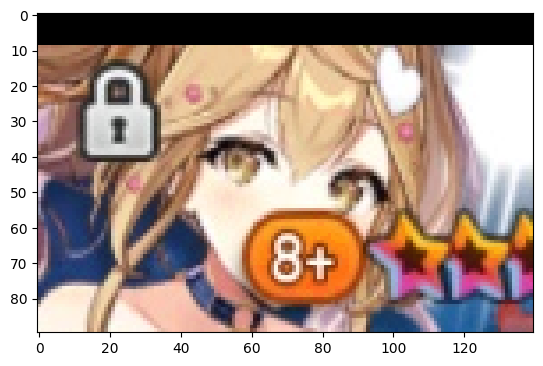

In [41]:
from matplotlib import pyplot as plt
import numpy as np
img, label = dataset[20]
img = (img.numpy().transpose((1,2,0))*255).astype(np.uint8)
plt.imshow(img[:,:,::-1])

In [18]:
dataset.map_id2name[label]

'伊芙丽娜'

## 训练网络

In [19]:
torch.cuda.is_available()

True

In [20]:
torch.cuda.set_device(0)

In [42]:
from torch.utils.data import DataLoader as DataLoader
loader = DataLoader(dataset, batch_size = 16, shuffle=True)

In [22]:
net = Net(class_num=len(dataset.map_id2name))
net.cuda()
net.train()

Net(
  (conv1): Conv2d(
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=8)
  )
  (conv2): Conv2d(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=16)
  )
  (conv3): Conv2d(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (fc): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [23]:
from torcheval.metrics import MulticlassAccuracy
metric = MulticlassAccuracy(device="cuda")

In [43]:
from tqdm import tqdm
optimizer = torch.optim.AdamW(params = net.parameters(), lr=1e-3)
maxepoch = 1000
for epoch in range(maxepoch):
    pbar = tqdm(loader)
    total_loss,cnt = 0,0
    metric.reset()
    for img,label in pbar:
        img = img.cuda()
        label = label.cuda().long()
        out = net(img)
        metric.update(out,label)
        loss = criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
        pbar.set_description("epoch: {} , loss: {:.4f}, acc: {:.2f}".format(epoch, total_loss/cnt, metric.compute()))

epoch: 999 , loss: 0.4235, acc: 0.98: 100%|████████████████████████████████████████████| 18/18 [00:00<00:00, 19.15it/s]


In [44]:
torch.save(net,"../assert/hero_avatar.pt")

In [152]:
## test network inference

In [45]:
net.eval()
img = imread_chinese_path(r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\resources\photo\avatar\木龙.jpg")
#img = cv2.resize(img, (64,48))
input = torchvision.transforms.ToTensor()(img)
input = input.unsqueeze(0).cuda()
out = net(input)

In [46]:
dataset.map_id2name[out[0].argmax().item()]

'木龙'

## pytorch model to onnx

In [10]:
net = Net_feature()
model_state_dict = torch.load("../assert/hero_avatar.pt")

In [14]:
net.load_state_dict(model_state_dict.state_dict(),strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['cls_w'])

In [15]:
dummy_input = torch.randn(1, 3, 90, 140)

# 4. 使用torch.onnx.export()函数转换模型
torch.onnx.export(net.cpu(), dummy_input, "../assert/hero_avatar_feature.onnx")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### onnx inference

In [48]:
import numpy as np
import onnxruntime as ort
import torch
import torchvision.transforms as transforms

In [49]:
img = imread_chinese_path(r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\resources\photo\avatar\木龙.jpg")
#img = cv2.resize(img, (64,48))
input = torchvision.transforms.ToTensor()(img)
input = input.unsqueeze(0).numpy()

In [50]:
sess = ort.InferenceSession("../assert/hero_avatar.onnx")

In [51]:
inputs = {sess.get_inputs()[0].name: input}
outputs = sess.run(None, inputs)
predicted_class = np.argmax(outputs[0], axis=1)

In [52]:
predicted_class.item()

137

In [53]:
dataset.map_id2name[predicted_class.item()]

'木龙'

# write id 2 name

In [54]:
with open('../assert/id2name.txt','w') as f:
    for id,name in enumerate(dataset.map_id2name):
        f.write("{} {}\n".format(id, name))